In [1]:
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
notebook_rc = dict(mpl.rcParams)
# mpl.rcParams.update(notebook_rc)

import plotly
import plotly.plotly as py
import plotly.tools as tls
import cufflinks as cf

from numpy.lib.stride_tricks import as_strided

from mypy.theutility import *
from mypy.quickvis import canvas
#canvas(12.3, 12.3)

from scipy.spatial.distance import pdist, cdist, squareform
import scipy.linalg as linalg
from time import time

from pathlib import Path
data_dir = Path('./cinc2011/')

In [30]:
# cool list
# good: 
# bad: 132
def flatten_dimensions(a, lo, hi):
   return a.reshape(a.shape[:lo] + (prod(a.shape[lo:hi+1]),) + a.shape[hi+1:])

In [3]:
train_dir = data_dir / 'set-a'
idents_list = []
for suffix in '', '-acceptable', '-unacceptable':
    _name = 'RECORDS' + suffix
    with (train_dir / _name).open('r') as f:
        idents_list.append([int(x) for x in f.readlines()])
[ident_all, ident_good, ident_bad] = [sp.asarray(idents) for idents in idents_list]
orig_tables = {}
for i in ident_all:
    orig_tables[i] = pd.read_csv(train_dir / '{}.txt'.format(i), header=None, usecols=range(1, 13))
    orig_tables[i].columns = 'I II III aVR aVL aVF V1 V2 V3 V4 V5 V6'.split()

In [4]:
def _normalize(table):
    table_min, table_max = table.min(), table.max()
    table_range = table_max - table_min
    return (table - table_min) / (sp.where(table_range == 0, 1, table_range))
norm_tables = dictmap(_normalize, orig_tables)
def _downsample(table):
    s = (table.index.to_series() / 5).astype(table.index.dtype)
    return table.groupby(s).mean()
downsamp_tables = dictmap(_downsample, norm_tables)

In [5]:
thetables = downsamp_tables
table = thetables[ident_bad[132]]
(table + list(range(11, -1, -1))).iplot()

In [21]:
def _variation(table):
    return table.diff().abs().sum()
variation_tables = dictmap(_variation, norm_tables)
variations_good = sp.stack(variation_tables[i].as_matrix() for i in ident_good)
variations_bad = sp.stack(variation_tables[i].as_matrix() for i in ident_bad)

<IPython.core.display.Javascript object>


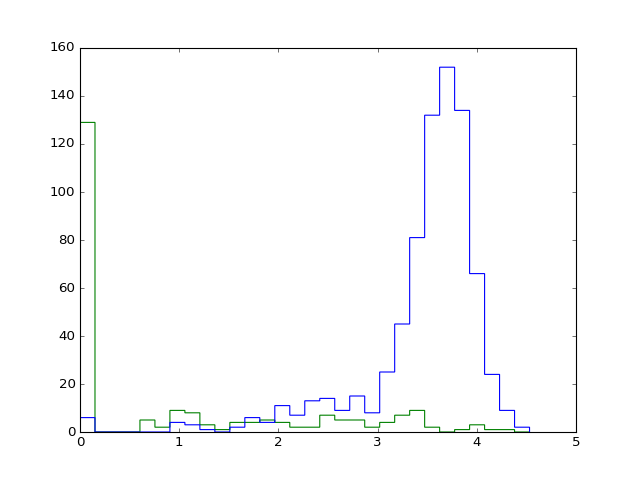

IDs of good records with a flat signal (0 variation) in one lead:  [1968453 2080991 2151032 2536401 2537839 2883516]
The number of good records with no flat signals:  767
The number of bad records with no flat signals:  96


In [22]:
_v = variations_good, variations_bad
plt.hist([sp.log(v.min(axis=1) + 1) for v in _v], bins=30, histtype='step')
ident_good_missing = ident_good[sp.where((variations_good == 0).sum(axis=1) == 1)[0]]
print('IDs of good records with a flat signal (0 variation) in one lead: ', ident_good_missing)
ident_good_complete = ident_good[sp.where((variations_good == 0).sum(axis=1) == 0)[0]]
print('The number of good records with no flat signals: ', len(ident_good_complete))
ident_bad_complete = ident_bad[sp.where((variations_bad == 0).sum(axis=1) == 0)[0]]
print('The number of bad records with no flat signals: ', len(ident_bad_complete))
ident_all_complete = sp.concatenate([ident_good_complete, ident_bad_complete])

In [23]:
theident_all = ident_all_complete
theident_good = ident_good_complete
theident_bad = ident_bad_complete

from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
_label = sp.in1d(theident_all, theident_bad)
_train, _validation = skf.split(theident_all, _label).__next__()
ident_train = theident_all[_train]
label_train = _label[_train]
ident_validation = theident_all[_validation]
label_validation = _label[_validation]

In [33]:
def rolling_window(x, window, axis):
    if axis < 0:
        axis += len(x.shape)
    shape = x.shape[:axis] + (x.shape[axis] - window + 1, window) + x.shape[axis + 1:]
    strides = x.strides[:axis] + (x.strides[axis],) + x.strides[axis:]
    return as_strided(x, shape=shape, strides=strides)
thetables = downsamp_tables
n_samples = 40
sample_length = 80
def sample_record(i):
    matrix = thetables[i].as_matrix()
    samples_idx = sp.random.permutation(matrix.shape[0] - sample_length + 1)[:n_samples]
    windows = rolling_window(matrix, sample_length, 0)
    return windows[samples_idx], samples_idx
def create_samples(ident):
    sr = [sample_record(i) for i in ident]
    sample_windows = sp.stack([a[0] for a in sr])
    sample_indices = sp.stack([a[1] for a in sr])
    return sample_windows, sample_indices

In [32]:
symscale = lambda M, x: x[:, sp.newaxis] * M * x
alpha = .5
nnn = 800

In [36]:
t0 = time()
sample_windows0, sample_indices0 = create_samples(ident_train)
XX0 = flatten_dimensions(sample_windows0, 0, 1)
X_0 = flatten_dimensions(XX0, 1, 2)
l0 = sp.concatenate([lbl * sp.ones(n_samples) for lbl in label_train])

W0 = sp.zeros((len(XX0), len(XX0)))
sigma0_alt = [None for i in range(12)]
d0_alt = [None for i in range(12)]
for lead in range(12):
    _X = XX0[..., lead]
    _E = squareform(pdist(_X, 'sqeuclidean'))
    sigma0_alt[lead] = sp.sqrt(sp.sort(_E, axis=0)[nnn])
    _W = sp.exp(-symscale(_E, 1 / (sigma0_alt[lead] + 0.00001)))
    _d = _W.sum(axis=1)
    # alpha normalization
    _W = symscale(_W, _d ** -alpha)
    # make transition matrix
    d0_alt[lead] = _W.sum(axis=1)
    W0 += (1 / d0_alt[lead])[:, sp.newaxis] * _W
d0 = W0.sum(axis=0)
A0 = (1 / d0)[:, sp.newaxis] * W0

# find eigenvectors of diffusion transition matrix
mu, U = sp.linalg.eig(A0)
# eigh puts eigenvalues in ascending order, but we want descending order
order = sp.argsort(-mu)
mu = mu[order]
U = U.T[order].T

t1 = time()
t1 - t0

MemoryError: 

In [21]:
Y0 = sp.real(U)

trace = go.Scatter3d(
    x=Y0[:, 1],
    y=Y0[:, 2],
    z=Y0[:, 3],
    mode='markers',
    marker=dict(
        size='2',
        color=label_train * 1,
        showscale=True,
        colorscale='Jet',
        opacity=.8
    )
)
data = [trace]
py.iplot(data)

In [ ]:
t0 = time()
XX = sp.concatenate([create_samples(i) for i in ident_train])
X_ = XX.reshape((XX.shape[0], XX.shape[1] * XX.shape[2]))
l = sp.concatenate([lbl * sp.ones(n_samples) for lbl in label_train])

def y(XX):
    W = sp.zeros((len(XX), len(XX)))
    for lead in range(12):
        _X0 = XX0[..., lead]
        _X = XX[..., lead]
        _E = cdist(_X, _X0, 'sqeuclidean')
        _sigma = sp.sqrt(sp.sort(_E, axis=1)[:, nnn])
        _W = sp.exp(-(1 / (_sigma + 0.00001))[:, sp.newaxis] * _E * (1 / (sigma0_alt[lead] + 0.00001)))
        _d = _W.sum(axis=1)
        _W = (_d ** -alpha)[:, sp.newaxis] * _W * (d0_alt[lead] ** -alpha)
        _d = _W.sum(axis=1)
        W += (1 / _d)[:, sp.newaxis] * _W
    d = W.sum(axis=0)
    A = (1 / d)[:, sp.newaxis] * W
    return sp.real(A @ U / mu)
Y = y(XX)

t1 = time()
t1 - t0

In [23]:
trace = go.Scatter3d(
    x=Y[:, 1],
    y=Y[:, 2],
    z=Y[:, 3],
    mode='markers',
    marker=dict(
        size='2',
        color=label_train * 1,
        showscale=True,
        colorscale='Jet',
        opacity=.8
    )
)
data = [trace]
py.iplot(data)

In [ ]:
XX_test = sp.concatenate([create_samples(i) for i in ident_validation])
X_test = XX_test.reshape((XX_test.shape[0], XX_test.shape[1] * XX_test.shape[2]))
l_test = sp.concatenate([lbl * sp.ones(n_samples) for lbl in label_validation])
Y_test = y(X_test)

In [26]:
pd.DataFrame(sp.real(mu)).iplot()

In [69]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(sp.concatenate([X_0, X_]), sp.concatenate([l0, l]))
pred = xgb.predict(X_test)

In [49]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(sp.concatenate([X_0, X_]), sp.concatenate([l0, l]))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
XX_test = sp.concatenate([create_samples(i) for i in ident_validation])
X_test = XX_test.reshape((XX_test.shape[0], XX_test.shape[1] * XX_test.shape[2]))
l_test = sp.concatenate([lbl * sp.ones(n_samples) for lbl in label_validation])
logistic.score(X_test, l_test)
pred = logistic.decision_function(X_test)

0.876

In [72]:
(((pred > 0) - l_test) == 1).sum()

115

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(3, perplexity=30)
t0 = time()
fitted = tsne.fit_transform(XX0.reshape((XX0.shape[0], XX0.shape[1] * XX0.shape[2])))
t1 = time()
t1 - t0

273.0242862701416

In [39]:
trace = go.Scatter3d(
    x=fitted[:, 0],
    y=fitted[:, 1],
    z=fitted[:, 2],
    mode='markers',
    marker=dict(
        size='2',
        color=label_train * 1,
        showscale=True,
        colorscale='Jet',
        opacity=.8
    )
)
data = [trace]
py.iplot(data)

In [82]:
M = sp.array([[1,2],[3,4]])
x = sp.array([1,10])
M.sum(axis=1)

array([3, 7])

In [69]:
import plotly 
plotly.tools.set_credentials_file(username='michaely', api_key='G6eLVa3Tt5aFJQQMqvgg')